# YOLO-v1 Implementation from Scratch

This script addresses complete implementation of [YOLO-v1](https://arxiv.org/pdf/1506.02640) from obtatining data to training and testing

## 1. Data Preparation

YOLO-v1 is trained on [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/index.html). However, YOLO-v1 has its own target representation. 
Therefore, the VOC dataset's target format must be converted to YOLO format. 

### 1.1 Downloading data and Conversion into YOLO-styled target format.

The VOC dataset's target is composed as follows.

- voc_target: {'annotation': 
        {'folder': 'VOC2012', 
        'filename': '2008_000002.jpg', 
        'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 
        'size': {'width': '500', 'height': '375', 'depth': '3'}, 
        'segmented': '0', 
        **'object': [{'name': 'tvmonitor', 'pose': 'Frontal', 'truncated': '0', 'occluded': '0', 'bndbox': {'xmin': '34', 'ymin': '11', 'xmax': '448', 'ymax': '293'}, 'difficult': '0'}]**
        }}

YOLO-v1 divides the image into an S×S grid, with each cell predicting up to 2 bounding boxes—each with (x_center, y_center, width, height, confidence)—and one class out of 20. Hence, the target tensor has shape (S, S, 5×B + C), where B = 2 and C = 20.

- yolo_target = (S, S, 2*B + C) = (7, 7, 30), (S = 7, B = 2, C = 20)

As a result, the values of the **'object'** key from target are transformed to have (S, S, 2*B + C)

Obtaining data and the conversion is done with **VOC_to_YOLO_Dataset**. Please refer to the **data.py** for detailed conversion process.

In [1]:
#from data_copy import VOC_to_YOLO_Dataset
from data import VOC_to_YOLO_Dataset
yolo_dataset = VOC_to_YOLO_Dataset(use_manual=True, augment=True, normalize=True)


image, target= yolo_dataset[0][0], yolo_dataset[0][1]
print(f"The shape of an image:{image.numpy().shape}") 
print(f"The shape of a target:{target.numpy().shape}")
print(f"The length of dataset: {len(yolo_dataset)}")

The shape of an image:(3, 448, 448)
The shape of a target:(7, 7, 30)
The length of dataset: 17125


### 1.2 Data split
The dataset is split into training and testing sets with an 80/20 ratio.

In [2]:
from torch.utils.data import random_split
import torch

torch.manual_seed(42) 

train_size = int(0.8 * len(yolo_dataset))
test_size = len(yolo_dataset) - train_size

yolo_train_dataset, yolo_test_dataset = random_split(yolo_dataset, [train_size, test_size])

print(f"Train ratio and len: {int(len(yolo_train_dataset)/len(yolo_dataset)*100)}%, {len(yolo_train_dataset)}")
print(f"Test ratio and len: {int(len(yolo_test_dataset)/len(yolo_dataset)*100)}%, {len(yolo_test_dataset)}")  
# "Train size: 80%, test size: 2308) 

Train ratio and len: 80%, 13700
Test ratio and len: 20%, 3425


### 1.3 Create dataloaders

In [3]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import config

train_dataloader = DataLoader(
    yolo_train_dataset,
    batch_size=config.BATCH_SIZE, # 64
    num_workers=8,
    persistent_workers=True,
    drop_last=True,
    shuffle=True
)
test_dataloader = DataLoader(
    yolo_test_dataset,
    batch_size=config.BATCH_SIZE, # 64
    num_workers=8,
    persistent_workers=True,
    drop_last=True
)

initial_batch = next(iter(train_dataloader))
images, targets = initial_batch[0], initial_batch[1]

print(f"How many batches: Train:{len(train_dataloader)}, Test:{len(test_dataloader)}")
print(f"the shape of batched images: {images.numpy().shape}") # the shape of batched images: (16, 3, 448, 448)
print(f"the shape of batched targets: {targets.numpy().shape}") # the shape of batched targets: (16, 7, 7, 30)


How many batches: Train:285, Test:71
the shape of batched images: (48, 3, 448, 448)
the shape of batched targets: (48, 7, 7, 30)


### 1.4 Visualization with created dataloaders

An image from the dataloader is visualized with its corresponding target bounding boxes, allowing us to verify that data preparation has been done correctly.

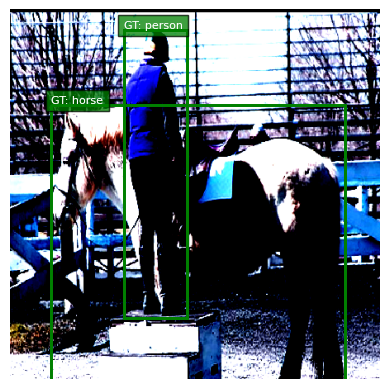

In [ ]:
import random
from visualization import visualize_gt

# The initial batch of train_dataloader
images, targets= next(iter(train_dataloader))

# Pick randomly one sample
random_i = random.choice(range(len(images)))
img_tensor = images[random_i]  # shape: (3, 448, 448)
target_tensor = targets[random_i]  # shape: (7, 7, 30)

visualize_gt(img_tensor, target_tensor)



## 2. Model Construction

Now that the data has been prepared, we move on to designing the YOLO-v1 model from scratch.

### 2.1 Model interpretation based on the paper

According to the original paper, YOLO-v1 consists of six convolutional blocks for feature extraction, followed by a prediction head that outputs bounding boxes and class probabilities.


| **Block**       | **Layers**                                                                               | **Output Shape** |
| --------------- | ---------------------------------------------------------------------------------------- | ---------------- |
| Conv Block 1    | Conv(7×7, 64, stride=2) → LeakyReLU → MaxPool(2×2)                                       | 112×112          |
| Conv Block 2    | Conv(3×3, 192, stride=1) → LeakyReLU → MaxPool(2×2)                                      | 56×56            |
| Conv Block 3    | Conv(1×1, 128) → Conv(3×3, 256) → Conv(1×1, 256) → Conv(3×3, 512) → MaxPool(2×2)         | 28×28            |
| Conv Block 4    | \[Conv(1×1, 256) → Conv(3×3, 512)] × 4 → Conv(1×1, 512) → Conv(3×3, 1024) → MaxPool(2×2) | 14×14            |
| Conv Block 5    | \[Conv(1×1, 512) → Conv(3×3, 1024)] × 2 → Conv(3×3, 1024) → MaxPool(2×2)                 | 7×7              |
| Conv Block 6    | Conv(3×3, 1024) → Conv(3×3, 1024)                                                        | 7×7              |
| Prediction Head | FC(1024×7×7 → 4096) → LeakyReLU → Dropout → FC(4096 → S×S×(B×5 + C))                     | S×S×(B×5 + C)    |



### 2.2 Model implmentation

Let's create the model using six conv blocks and one prediction head.

In [5]:
import torch.nn as nn
import torch
import config


S = config.S # the entire image is divided into SxS(=7x7) cells
B = config.B # a cell predicts up to B(=2) bounding boxes
C = config.C # The number of classes is C(=20)


class Yolov1(nn.Module):
    """
    A model reimplementation of the YOLO (You Only Look Once) object detection architecture.

    This model replicates the original paper's architecture as closely as possible.
    As described in the paper, input shape: (Batch, 3, 448, 448), output shape: (Batch, S, S, B*5+20)
    """
    def __init__(self):
        super().__init__()

        self.Conv_block1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                                    out_channels=64,
                                                    kernel_size=7,
                                                    stride=2,
                                                    padding=3), # 448 --> 224
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=2)) # 224 --> 112
        self.Conv_block2 = nn.Sequential(nn.Conv2d(64, 
                                                    192,
                                                    kernel_size=3,
                                                    padding=1 # 112 --> 112
                                                    ),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=2)) # 112 -> 56
        self.Conv_block3 = nn.Sequential(nn.Conv2d(192,
                                                    128,
                                                    kernel_size=1, # 56 --> 56
                                                    ),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Conv2d(128,
                                                    256,
                                                    kernel_size=3,
                                                    padding=1), # 56 --> 56
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Conv2d(256,
                                                    256,
                                                    kernel_size=1), # 56 --> 56
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Conv2d(256,
                                                    512,
                                                    kernel_size=3,
                                                    padding=1),  # 56 --> 56
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=2))# 56 --> 28)
        Conv_block4 = []
        for _ in range(4):
            Conv_block4.append(nn.Conv2d(512, 256, kernel_size=1))
            Conv_block4.append(nn.LeakyReLU(0.1, inplace=True))
            Conv_block4.append(nn.Conv2d(256, 512, kernel_size=3, padding=1))
            Conv_block4.append(nn.LeakyReLU(0.1, inplace=True))
        
        Conv_block4.append(nn.Conv2d(512, 512, kernel_size=1))
        Conv_block4.append(nn.LeakyReLU(0.1, inplace=True))
        Conv_block4.append(nn.Conv2d(512, 1024, kernel_size=3, padding=1))
        Conv_block4.append(nn.LeakyReLU(0.1, inplace=True))
        Conv_block4.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 28 --> 14
        
        self.Conv_block4 = nn.Sequential(*Conv_block4)

        Conv_block5 = []

        for _ in range(2):
            Conv_block5.append(nn.Conv2d(1024, 512, kernel_size=1))
            Conv_block5.append(nn.LeakyReLU(0.1, inplace=True))
            Conv_block5.append(nn.Conv2d(512, 1024, kernel_size=3, padding=1))
            Conv_block5.append(nn.LeakyReLU(0.1, inplace=True))

        Conv_block5.append(nn.Conv2d(1024, 1024, kernel_size=3, padding=1))
        Conv_block5.append(nn.LeakyReLU(0.1, inplace=True))
        Conv_block5.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 14 --> 7

        self.Conv_block5 = nn.Sequential(*Conv_block5)

        self.Conv_block6 = nn.Sequential(nn.Conv2d(1024,1024, kernel_size=3, padding=1),
                                          nn.LeakyReLU(0.1, inplace=True),
                                          nn.Conv2d(1024,1024, kernel_size=3, padding=1),
                                          nn.LeakyReLU(0.1, inplace=True))
        
        self.prediction_head = nn.Sequential(nn.Linear(in_features=1024*7*7, out_features=4096),
                                             nn.LeakyReLU(0.1, inplace=True), 
                                             nn.Dropout(0.5),
                                             nn.Linear(in_features=4096,
                                                       out_features=S*S*(B*5 + C))) 
        
    def forward(self,x):
        x = self.Conv_block1(x)
        x = self.Conv_block2(x)
        x = self.Conv_block3(x)
        x = self.Conv_block4(x)
        x = self.Conv_block5(x)
        x = self.Conv_block6(x)
        x = x.view(x.size(0), -1)
        x = torch.reshape(self.prediction_head(x), #
                          (x.shape[0],S, S, B*5 + C))

        return x


### 2.3 Model inspection

Let's test the model with a random tensor and see how well it is built using `summary`.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
 
model_0 = Yolov1().to(device)
random_input = torch.randn((64, 3, 448, 448)).to(device)
random_output = model_0(random_input) # should be (64, 7, 7, 30)
print(f"Random output shape: {random_output.shape}")  # should be (64, 7, 7, 30)

Random output shape: torch.Size([64, 7, 7, 30])


In [7]:
# Print a summary using torchinfo (uncomment for actual output)
from torchinfo import summary

summary(model=model_0, 
        input_size=(64, 3, 448, 448),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Yolov1 (Yolov1)                          [64, 3, 448, 448]    [64, 7, 7, 30]       --                   True
├─Sequential (Conv_block1)               [64, 3, 448, 448]    [64, 64, 112, 112]   --                   True
│    └─Conv2d (0)                        [64, 3, 448, 448]    [64, 64, 224, 224]   9,472                True
│    └─LeakyReLU (1)                     [64, 64, 224, 224]   [64, 64, 224, 224]   --                   --
│    └─MaxPool2d (2)                     [64, 64, 224, 224]   [64, 64, 112, 112]   --                   --
├─Sequential (Conv_block2)               [64, 64, 112, 112]   [64, 192, 56, 56]    --                   True
│    └─Conv2d (0)                        [64, 64, 112, 112]   [64, 192, 112, 112]  110,784              True
│    └─LeakyReLU (1)                     [64, 192, 112, 112]  [64, 192, 112, 112]  --                   --
│    └─MaxPool2d (2)

### 3. Training and Testing

Now we have both data and model needed for training.

This section covers 
1. YOLO-v1's loss fucntion 
2. Prep for training (optimizer with scheduler)
3. Training and testing
4. Visualization of predicted bounding boxes

### 3.1 Loss function

YOLO-v1's loss function = Localization error + confidence error + classification error

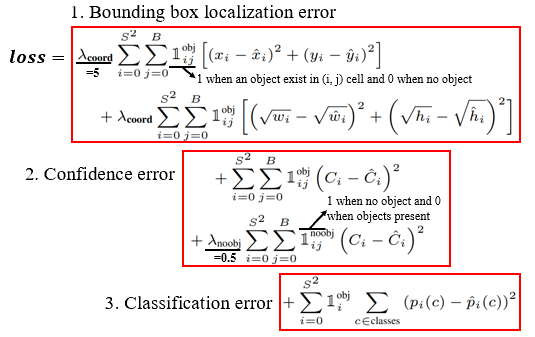

 the confidence indicates whether an object is present in a cell. It is calculated by multiplying the objectness probability with the Intersection over Union (IoU). 

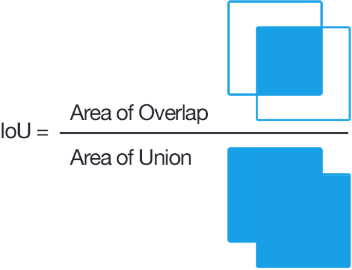

In [8]:
import torch
import config
from torch import nn as nn
from torch.nn import functional as F
from utils import get_iou, bbox_attr


class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l_coord = 5
        self.l_noobj = 0.5

    def forward(self, p, a):
        # Calculate IOU of each predicted bbox against the ground truth bbox
        iou = get_iou(p, a)                     # (batch, S, S, B, B)
        max_iou = torch.max(iou, dim=-1)[0]     # (batch, S, S, B)

        # Get masks
        bbox_mask = bbox_attr(a, 4) > 0.0
        p_template = bbox_attr(p, 4) > 0.0
        obj_i = bbox_mask[..., 0:1]         # 1 if grid I has any object at all
        responsible = torch.zeros_like(p_template).scatter_(       # (batch, S, S, B)
            -1,
            torch.argmax(max_iou, dim=-1, keepdim=True),                # (batch, S, S, B)
            value=1                         # 1 if bounding box is "responsible" for predicting the object
        )
        obj_ij = obj_i * responsible        # 1 if object exists AND bbox is responsible
        noobj_ij = ~obj_ij                  # Otherwise, confidence should be 0

        # XY position losses
        x_losses = mse_loss(
            obj_ij * bbox_attr(p, 0),
            obj_ij * bbox_attr(a, 0)
        )
        y_losses = mse_loss(
            obj_ij * bbox_attr(p, 1),
            obj_ij * bbox_attr(a, 1)
        )
        pos_losses = x_losses + y_losses
        # print('pos_losses', pos_losses.item())

        # Bbox dimension losses
        p_width = bbox_attr(p, 2)
        a_width = bbox_attr(a, 2)
        width_losses = mse_loss(
            obj_ij * torch.sign(p_width) * torch.sqrt(torch.abs(p_width) + config.EPSILON),
            obj_ij * torch.sqrt(a_width)
        )
        p_height = bbox_attr(p, 3)
        a_height = bbox_attr(a, 3)
        height_losses = mse_loss(
            obj_ij * torch.sign(p_height) * torch.sqrt(torch.abs(p_height) + config.EPSILON),
            obj_ij * torch.sqrt(a_height)
        )
        dim_losses = width_losses + height_losses
        # print('dim_losses', dim_losses.item())

        # Confidence losses (target confidence is IOU)
        obj_confidence_losses = mse_loss(
            obj_ij * bbox_attr(p, 4),
            obj_ij * torch.ones_like(max_iou)
        )
        # print('obj_confidence_losses', obj_confidence_losses.item())
        noobj_confidence_losses = mse_loss(
            noobj_ij * bbox_attr(p, 4),
            torch.zeros_like(max_iou)
        )
        # print('noobj_confidence_losses', noobj_confidence_losses.item())

        # Classification losses
        class_losses = mse_loss(
            obj_i * p[..., :config.C],
            obj_i * a[..., :config.C]
        )
        # print('class_losses', class_losses.item())

        total = self.l_coord * (pos_losses + dim_losses) \
                + obj_confidence_losses \
                + self.l_noobj * noobj_confidence_losses \
                + class_losses
        return total / config.BATCH_SIZE


def mse_loss(a, b):
    flattened_a = torch.flatten(a, end_dim=-2)
    flattened_b = torch.flatten(b, end_dim=-2).expand_as(flattened_a)
    return F.mse_loss(
        flattened_a,
        flattened_b,
        reduction='sum'
    )


### 3.2 Optimizer and Training Schedule Setup

Let's define the optimizer and configure the training schedule to replicate the one specified in the paper.

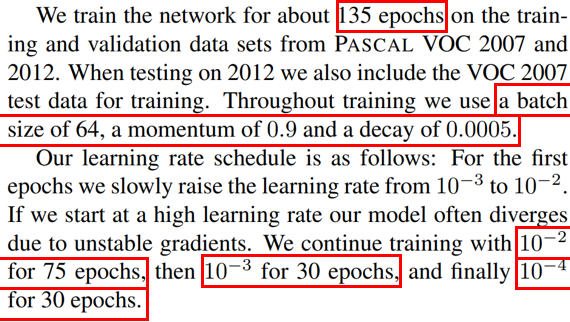

Given the paper, the entire 135 epochs are composed of:

1. 10^-3 for 75 epochs
2. 10^-4 for 30 epochs
3. 10^-5 for 30 epochs

In [9]:
from loss import YoloLoss
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR

loss_fn = YoloLoss()  
optimizer = optim.Adam(model_0.parameters(),lr=1e-3)
epochs = 135
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
scheduler = MultiStepLR(optimizer, milestones=[70, 100], gamma=0.1)

Record the training with `SummaryWriter` in `tensorboard`, 

In [10]:
from helper_functions import create_writer

writer_yolo = create_writer(experiment_name=f"{epochs}_1e-3_{scheduler.milestones}_{scheduler.gamma}",
                  model_name="yolo_v1")

[INFO] Created SummaryWriter, saving to: runs/2025-06-12/135_1e-3_Counter({70: 1, 100: 1})_0.1/yolo_v1...


### 3.3 Training and testing

Execute training with the defined loss, optimizer, and scheduler.

Please refer to `train.py` for detailed implementation of train and test step

In [1]:
from train import train

train(model=model_0,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        epochs=epochs,
        device=device,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        writer=writer_yolo)

NameError: name 'model_0' is not defined

### 3.4 Visualization of predicted bounding boxes

Let's visualize the predicted bouding boxes with ground truth

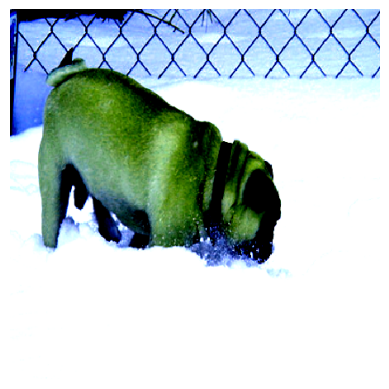

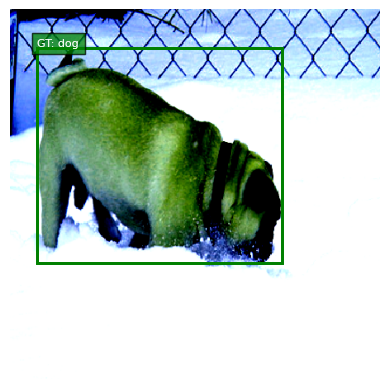

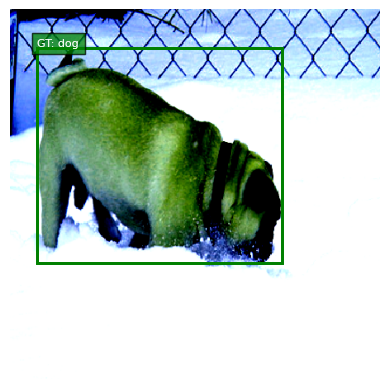

In [ ]:
from visualization import visualize_gt, visualize_pred, visualize_pred_with_gt
# test the model
images, targets= next(iter(test_dataloader))

# Pick randomly one sample
random_indexes = random.sample(range(len(images)), 1)

img_tensors = [images[i] for i in random_indexes]
target_tensors = [targets[i] for i in random_indexes]  # shape: (7, 7, 30)
img_tensor = torch.stack(img_tensors)  # shape: (4, 3, 448, 448)

model_0.eval()
with torch.inference_mode():
    test_output = model_0(img_tensor.to(device))

for i in range(len(random_indexes)):
    visualize_pred(img_tensors[i], test_output[i].cpu())
    visualize_gt(img_tensors[i], target_tensors[i])
    visualize_pred_with_gt(img_tensors[i], test_output[i].cpu(), target_tensors[i])


### 4. Save, load, and test

In [13]:
from pathlib import Path
import time
root_path = Path('checkpoints')
if not root_path.exists():
    root_path.mkdir(parents=True, exist_ok=True)
timestamp = time.strftime("%Y%m%d-%H%M%S")
save_path = root_path / f'yolo_model_{timestamp}.pth'
torch.save(model_0.state_dict(), save_path)

In [11]:
from pathlib import Path
from model import Yolo
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_0 = Yolo().to(device)
root_path = Path('checkpoints')

checkpoint_files = list(root_path.glob('*.pth'))
if not checkpoint_files:
    raise ValueError("No checkpoint found")

load_path = checkpoint_files[0]
model_0.load_state_dict(torch.load(load_path, map_location=device))

/tmp/ipykernel_56248/4037575393.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_0.load_state_dict(torch.load(load_path, map_location=device))


<All keys matched successfully>

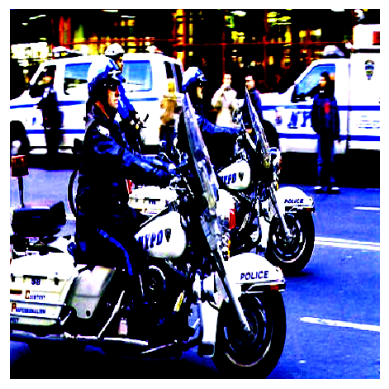

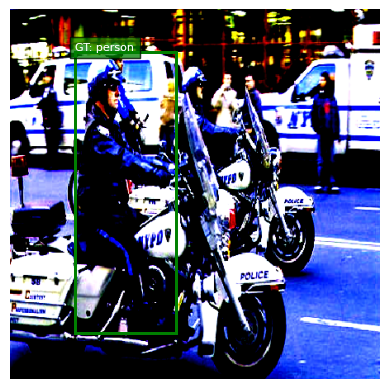

In [ ]:
from visualization import visualize_pred, visualize_gt
# test the model
images, targets= next(iter(test_dataloader))

# Pick randomly one sample
random_indexes = random.sample(range(len(images)), 1) 

img_tensors = [images[i] for i in random_indexes]
target_tensors = [targets[i] for i in random_indexes]  
img_tensor = torch.stack(img_tensors)  

model_0.eval()
with torch.inference_mode():
    test_output = model_0(img_tensor.to(device))


for i in range(len(random_indexes)):
    visualize_pred(img_tensors[i], test_output[i].cpu())
    visualize_gt(img_tensors[i], target_tensors[i])
